In [1]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE
import seaborn as sns
from typing import Literal

In [2]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i + 1], t2s[met_i - 1:met_i + 1], M_0s[met_i - 1:met_i + 1]
ws[0] = ws[1]
t2s[0] = t2s[1]
M_0s[0] = M_0s[1]
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


In [3]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

In [4]:
L = 0.4
noise_threshold = 30
L_ = int(L*sig.size)

In [5]:
offsets = 10**-np.arange(0.5, 3.0, 0.1)
print(offsets)
tns = np.arange(1.0, 2.5, 0.1)
print(tn)


[0.31622777 0.25118864 0.19952623 0.15848932 0.12589254 0.1
 0.07943282 0.06309573 0.05011872 0.03981072 0.03162278 0.02511886
 0.01995262 0.01584893 0.01258925 0.01       0.00794328 0.00630957
 0.00501187 0.00398107 0.00316228 0.00251189 0.00199526 0.00158489
 0.00125893]
1.0


In [6]:
n_avgs = 10
L_ = int(L*2048)
shape = (offsets.size, tns.size, L_)
s0s_, phis_, omegas_, t2s_ = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)

In [7]:
rerun = False
filename_end = ""
folder_name = "files/"
subfolder_name = "time_varying/"

In [8]:
if rerun == True:
    for i in range(tns.size):
        for j in range(offsets.size):
            ws[1] = ws[0] + offsets[j]
            pop = pymri.population(ws, t2s, M_0s, spins_phi)
            
            t0, tn, dt, B0 = pymri.setup_sim_t(0.0, tns[i], 2048, 3.0)

            sig, t = pymri.population_transverse_decay( t0, tn, dt, pop)
            f_sig, z, r = pymri.filter_sig(sig, L, noise_threshold, return_poles_and_res=True, return_full_arrays=True)
            s0s_[j, i, :], phis_[j, i, :], omegas_[j, i, :], t2s_[j, i, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
            t2s_[j, i, :] = 1/t2s_[j, i, :]
            
            print(f"offset {offsets[j]} tn {tns[i]}")

In [9]:
if rerun == True:
    np.save(folder_name + subfolder_name + "s0s_" + filename_end, s0s_)
    np.save(folder_name + subfolder_name + "phis_" + filename_end, phis_)
    np.save(folder_name + subfolder_name + "omegas_" + filename_end, omegas_)
    np.save(folder_name + subfolder_name + "t2s_" + filename_end, t2s_)

In [10]:
if rerun == False:
    s0s_ = np.load(folder_name + subfolder_name + "s0s_" + filename_end + ".npy")
    phis_ = np.load(folder_name + subfolder_name + "phis_" + filename_end + ".npy")
    omegas_ = np.load(folder_name + subfolder_name + "omegas_" + filename_end + ".npy")
    t2s_ = np.load(folder_name + subfolder_name + "t2s_" + filename_end + ".npy")

In [29]:
i_tn = 0
i = 0

args = np.argsort(s0s_[:, i_tn, :], axis=1)

identified_s0 = np.sort(s0s_[i, i_tn, args[i, :]][L_ - 2: L_]) #filtra apenas os dois ultimos, correspondentes aos dois ultimos picos
identified_omega = np.sort(omegas_[i, i_tn, args[i, :]][L_ - 2: L_])
identified_phi = np.sort(phis_[i, i_tn, args[i, :]][L_ - 2: L_])
identified_t2 = np.sort(t2s_[i, i_tn, args[i, :]][L_ - 2: L_])

print("Offset \t\t\t tn")
print(offsets[i], "\t", tns[i_tn]) 
print("Original")
print(np.sort(np.array([ws[0], ws[0] + offsets[i]])))
print("Identificado")
print(identified_omega)
print("Erro")
print(np.sort(np.array([ws[0], ws[0] + offsets[i]])) - identified_omega)

Offset 			 tn
0.31622776601683794 	 1.0
Original
[2411.71251655 2412.02874432]
Identificado
[2411.71251655 2412.02874432]
Erro
[-2.05955075e-09  2.48019205e-09]


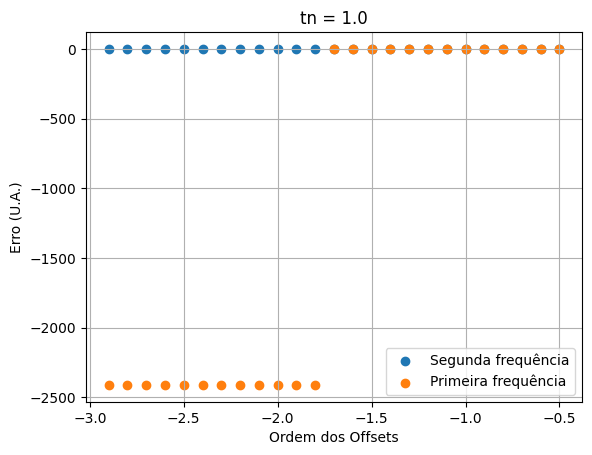

In [30]:
first_error, second_error = np.zeros_like(offsets), np.zeros_like(offsets)
for k in range(offsets.size):
    compare_arr = np.sort(omegas_[k, i_tn, args[k, :]][L_ - 2: L_])
    first_error[k] = compare_arr[0] - ws[0]
    second_error[k] = compare_arr[1] - (ws[0] + offsets[k])

# plt.figure(figsize=(10, 7))
plt.scatter(np.log10(offsets), second_error, label = f"Segunda frequência")
plt.scatter(np.log10(offsets), first_error, label = "Primeira frequência")
plt.xlabel("Ordem dos Offsets")
plt.ylabel("Erro (U.A.)")
plt.title(f"tn = {tns[i_tn]}")
plt.legend()
plt.grid()

A priori, parece que o tn, e consequentemente a resolução do problema, não fazem nenhuma diferença na fronteira de identificação dos dois picos.

In [ ]:
dt_ = (2.4 - 0.0)/2048

print((1/dt_/2048))

0.4166666666666667
